In [1]:
%pip install gutenberg > /dev/null
%pip install tiktoken > /dev/null

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

import logging
import os
from datetime import datetime

import asyncio
import aiohttp
from bs4 import  BeautifulSoup

import string
import re

from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers

from  collections import Counter, defaultdict

import tiktoken

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 


import matplotlib.pyplot as plt


import pickle
import time

BASE_PATH = "/home/miguel/Desktop/GPT/"

OUTPUT_FILE = BASE_PATH + "books/content.txt"
oneBook = BASE_PATH + "books/one.txt"
tenBooks = BASE_PATH + "books/ten.txt"
hundredBooks = BASE_PATH + "books/hundred.txt"

oneBook_model = BASE_PATH + 'models/oneBookGPT.pkl'
tenBooks_model = BASE_PATH + 'models/tenBooksGPT.pkl'
hundredBooks_model = BASE_PATH  + 'models/hundredBooks_model.pkl'


"""
Configuration
"""

tokenizer = tiktoken.get_encoding("gpt2")
torch.cuda.empty_cache()

### Extract DataSet 



In [2]:
class ExtractDataSet:
    def __init__(self, base_path):
        self.base_path = base_path
        self.url = 'https://www.gutenberg.org/browse/scores/top1000.php'
        self.csv_path = './books/booksList.csv'
        self._books = []
        self._books_content = []

        """
         DataSet Configuration
        """
        dataset_directory = os.path.join(self.base_path, 'books')
        os.makedirs(dataset_directory, exist_ok=True)

        """
        Logger Configuration
        """
        log_directory = os.path.join(self.base_path, 'logs/books')
        os.makedirs(log_directory, exist_ok=True)

        self.general_logger = self._get_logger('general')

    def _get_logger(self, log_name):
        logger = logging.getLogger(log_name)
        log_dir = os.path.join(self.base_path, "logs/books")

   

        log_file = os.path.join(log_dir, f"{log_name}_latest.log")

        if not logger.hasHandlers():
            handler = logging.FileHandler(log_file, mode='a')
            handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
            logger.addHandler(handler)
            logger.setLevel(logging.DEBUG)  


        return logger

    async def get_books(self)-> None:
        self.general_logger.info("Starting to fetch the books list...")

        async with aiohttp.ClientSession() as session:
            async with session.get(self.url) as response:
                try:
                    if response.status != 200:
                        raise ValueError("Error to get the books list.")
                    content = await response.text()
                    soup = BeautifulSoup(content, 'html.parser')
                    books_section = soup.find('ol')

                    for book in books_section.find_all('li'):
                        title = book.text.strip()
                        link = book.find('a')['href']
                        bookID = link.split('/')[-1]
                        self._books.append((bookID, title, f"https://www.gutenberg.org{link}"))
                    self.general_logger.info("Books list fetched successfully.")
                except aiohttp.ClientError as e:
                    self.general_logger.error(f"Error to get the books list: {e}")
                except ValueError as e:
                    self.general_logger.warning(e)
                except Exception as e:
                    self.general_logger.critical(f"Unexpected error to get the books list: {e}")

    def create_books_list(self)-> None:
        books_logger = self._get_logger('Creating list of books...')

        try:
            with open(self.base_path + 'books/booksList.csv', 'w', encoding='utf-8') as file:
                file.write("ID;TITLE;LINK\n")
                for book in self._books:
                    file.write(f"{str(book[0])};\"{str(book[1])}\";{str(book[2])}\n")
            books_logger.info("Books list created successfully.")
        except Exception as e:
            books_logger.critical(f"Failed to create books list: {e}")

            
    async def find_valid_book_url(self, session, book, content_logger, delay=5)-> None:
        book_urls = [
            f"https://www.gutenberg.org/files/{book[0]}/{book[0]}-0.txt",
            f"https://www.gutenberg.org/files/{book[0]}/{book[0]}.txt",
            f"https://www.gutenberg.org/cache/epub/{book[0]}/pg{book[0]}.txt"
        ]

        for url in book_urls:
            try:
                async with session.get(url) as response:
                    if response.status == 200:
                        text = await response.text()
                        content_logger.info(f'ID: {str([book[0]])}, Book: {str(book[1])}, URL: {url}')
                        return text
                        break
                    await asyncio.sleep(delay)
            except aiohttp.ClientError as e:
                content_logger.error(f"Error to get the book content of {str(book[1])} with ID {str(book[0])}: {e}")
            except Exception as e:
                content_logger.critical(f"Unexpected error to get the book content, try again: {e}")
        return None


    def clean_text(self, text:str)-> str:

         text = re.sub(r'\*\*\* START OF THE PROJECT GUTENBERG EBOOK .*?\*\*\*', '', text, flags=re.IGNORECASE)
         text = re.sub(r'\[Illustration\]', '', text)
         text = re.sub(r'\n{3,}', '\n', text)
         text = re.sub(r'\n', ' ', text)

         return text

        

    def get_book_content(self) -> None:
        self.general_logger.info("Extracting books content...")

        df_books = pd.read_csv(self.csv_path, sep=';', quotechar='"', encoding="utf-8")
        books_id = df_books['ID'].tolist()

        content_logger = self._get_logger("book_content")
        language_logger = self._get_logger("language_content")

        for id in books_id:  
            try:
                content_logger.info(f"Extracting content of book {id}")
                text = strip_headers(load_etext(id, mirror="https://www.gutenberg.org")).strip()

                text = text.lstrip('\ufeff')

                if text.startswith('<!DOCTYPE html>'):
                    content_logger.info(f"Skipping book {id} because it starts with <!DOCTYPE html>")
                    continue  

                common_english_words = ['the', 'and', 'to', 'in', 'a', 'that', 'is', 'The', 'And', 'To', 'I', 'That']
                word_count = sum(word in text for word in common_english_words)

                if word_count > 7:
                    language_logger.info(f"The book with {id} is in English")
                    cleaned_text = self.clean_text(text)
                    self._books_content.append([cleaned_text])
                else:
                    language_logger.info(f"The book with ID {id} is NOT in English.")
            except KeyboardInterrupt:
                content_logger.error(f"Process interrupted. Last book processed: {id}")
                raise
            except Exception as e:
                content_logger.error(f"An error occurred with book ID {id}: {e}")
                raise

        
    @staticmethod
    async def run_extraction():
        instace = ExtractDataSet(base_path=BASE_PATH)
        await instace.get_books()
        instace.create_books_list()

        instace.get_book_content()

        books_content = instace._books_content
        print(f"Done > number of books: {len(instace._books_content)}")

        return books_content


books_content = await ExtractDataSet.run_extraction()   

Done > number of books: 686


### Write books content

In [3]:
def write_book_content(outfile:str, numberBooks: int):
    processed_books_content = ""

    for i in range(numberBooks):

        text = "".join(books_content[i])

        pattern = re.compile(r'(\d+|[' + re.escape(string.punctuation) + '])')

        tokens = pattern.split(text)
        tokens = [token for token in tokens if token.strip()]
        tokens.append("<|endoftext|> ")

        joined_text = " ".join(tokens)

        processed_books_content += joined_text

    with open(outfile, "w", encoding="utf-8") as file:
        file.write(processed_books_content)

    print(f"El contenido procesado se ha guardado en {outfile}")

write_book_content(oneBook, 1) # one book
write_book_content(tenBooks, 10) # ten books
write_book_content(hundredBooks, 100) # hundred books
write_book_content(OUTPUT_FILE, len(books_content)) # complete dataset

El contenido procesado se ha guardado en /home/miguel/Desktop/GPT/books/one.txt
El contenido procesado se ha guardado en /home/miguel/Desktop/GPT/books/ten.txt
El contenido procesado se ha guardado en /home/miguel/Desktop/GPT/books/hundred.txt
El contenido procesado se ha guardado en /home/miguel/Desktop/GPT/books/content.txt


## Architecture

### Attention Module



$ \text{attn\_scores} = \frac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d_k}} $

- $ \mathbf{Q} $: query matrix
- $ \mathbf{K}^T$: key matrix 
- $ \sqrt{d_k}$: dimensionality of keys 


NOTE: It is the dimensionality of the keys (or queries), and it is used to scale the dot product value to prevent the values from becoming too large, that could cause the softmax function to become extemely sensitive and lose useful information




In [2]:
"""
Casual attention 
"""

class CasualAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout: float, qkv_bias: bool = False):
        super().__init__()

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)  
        )

    def forward(self, x):
     
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

       
        attn_scores = queries @ keys.transpose(-2, -1)  
        attn_scores = attn_scores.masked_fill(self.mask == 1, float('-inf'))

       
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec

"""
Masked Multi-Head Attention
"""

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length:int, dropout:float, num_heads:int=12, qkv_bias:bool = False):
        super().__init__()

        self.heads = nn.ModuleList(
            [CasualAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
        )

        # projects the concatenated tensor back into the original output dimension 
        self.W_out = nn.Linear(d_out * num_heads, d_out)


    def forward(self,x):
        head_outputs = [head(x) for head in self.heads]
        concat_output = torch.cat(head_outputs, dim=-1)
        output = self.W_out(concat_output)
        return output

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # prevent division by zero
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                    GELU(),
                                    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)
    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.attention = MultiHeadAttention(d_in = cfg["emb_dim"],
                                             d_out=cfg["emb_dim"] , 
                                             context_length=cfg["context_length"], 
                                             dropout=cfg["drop_rate"], 
                                             num_heads=cfg["n_heads"], 
                                             qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        """
        Pre-LayerNorm: Layer Normalization before MultiHeadAttention 
        and dropout (leads to better training dynamics).
        """

        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

### GPT Model

In [4]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        
        x = tok_embeds + pos_embeds  
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Read Text books content

In [5]:
def read_book_content(file):
    with open(file, "r", encoding='utf-8') as file:
        text_data = file.read()

    total_words = len(text_data.split())
    total_tokens = len(tokenizer.encode(text_data,allowed_special={"<|endoftext|>"}))

    print("Total words in the dataset: ", total_words)
    print("Total tokens in the dataset: ", total_tokens)

    return text_data

oneBookContent = read_book_content(oneBook)
tenBooksContent = read_book_content(tenBooks)
hundredBooksContent = read_book_content(hundredBooks)
# allBooksContent = read_book_content(OUTPUT_FILE)

Total words in the dataset:  85137
Total tokens in the dataset:  102099
Total words in the dataset:  2405533
Total tokens in the dataset:  3297428
Total words in the dataset:  19576744
Total tokens in the dataset:  27393195


### Tokenize content (Byte Pair encoding ) & Data Loaders

In [6]:
class GPTDataset(Dataset):
    
    def __init__(self, text:str, tokenizer, max_length:int, stride:int):
        
        self.input_ids: list = []
        self.target_ids: list = []

        
        token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        if len(token_ids) < max_length:
            raise ValueError("The text is to short for the max_length of the sequence")

        self.tokenLength : int = len(token_ids)

        for i in range(0, len(token_ids) - max_length, stride):
            """
            Uses sliding window to chunk the books into overlapping sequences of max_length
            """
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self)-> int:

        """
        returns the total number of rows in the dataset
        """

        return len(self.input_ids)
    
    def __getitem__(self, idx ):

        """
        returns the total number of rows in the dataset
        """
        return self.input_ids[idx], self.target_ids[idx]
    

def create_dataloader(text:str, max_length:int, stride:int,shuffle:bool, drop_last:bool, batch_size:int, num_workers:int)-> DataLoader:
    
    dataset = GPTDataset(text, tokenizer, max_length, stride)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last,num_workers=num_workers)

### Training Model

In [10]:
!mkdir logs/trainings loss_functions models

mkdir: cannot create directory ‘loss_functions’: File exists
mkdir: cannot create directory ‘models’: File exists


In [18]:
class TrainedGPTModel:
    def __init__(self, model, content, cfg, train_ratio, learning_rate, num_epochs, log_file_name):
        self.model = model
        self.cfg = cfg
        self.learning_rate = learning_rate

        self.logger = self.setup_logger('logs/trainings/'+ log_file_name)

        split_idx = int(train_ratio * len(content))
        self.train_data = content[:split_idx]
        self.val_data = content[split_idx:]

        self.train_loader = None
        self.val_loader = None

        self.num_epochs = num_epochs
        self.eval_freq = 500
        self.global_step = 0
        self.tokens_seen = 0

        self.train_losses = []
        self.val_losses = []
        self.track_tokens_seen = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def setup_logger(self, log_file):
        logger = logging.getLogger(log_file)
        logger.setLevel(logging.INFO)

        if not logger.hasHandlers():
            handler = logging.FileHandler(log_file, mode='w')  
            formatter = logging.Formatter('%(asctime)s - %(message)s')
            handler.setFormatter(formatter)
            logger.addHandler(handler)

        return logger



    def split_data(self):
        self.train_loader = create_dataloader(
            self.train_data, 
            batch_size=128, 
            max_length=self.cfg["context_length"],
            stride=self.cfg["context_length"], 
            drop_last=False, 
            shuffle=False, 
            num_workers=4
        )
        self.val_loader = create_dataloader(
            self.val_data, 
            batch_size=128, 
            max_length=self.cfg["context_length"],
            stride=self.cfg["context_length"], 
            drop_last=False, shuffle=False, 
            num_workers=4
        )
       
    def trainingPhase(self):

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-2)

        for epoch in range(self.num_epochs):
            for input_batch, target_batch in self.train_loader:
                optimizer.zero_grad()
                loss = self.calc_loss_batch(input_batch, target_batch, self.model, self.device)
                loss.backward()
                optimizer.step()

                self.tokens_seen += input_batch.numel()
                self.global_step += 1

                if self.global_step % self.eval_freq == 0:
                    train_loss, val_loss = self.evaluate_model()
                    self.train_losses.append(train_loss)
                    self.val_losses.append(val_loss)
                    self.track_tokens_seen.append(self.tokens_seen)

                    training_log = (
                        f"Epoch {epoch+1} (Step {self.global_step:06d}): "
                        f"Train loss {train_loss:.3f}, "
                        f"Val loss {val_loss:.3f}"
                    )

                    # print(f"Epoch {epoch+1} (Step {self.global_step:06d}): "
                    #       f"Train loss {train_loss:.3f}, "
                    #       f"Val loss {val_loss:.3f}")
                    
                    # print(training_log)
                    self.logger.info(training_log)

    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            train_loss = self.calc_loss_loader(self.train_loader, self.model, self.device)
            val_loss = self.calc_loss_loader(self.val_loader, self.model, self.device)
        self.model.train()
        return train_loss, val_loss

    def calc_loss_loader(self, data_loader, model, device, num_batches=None):
        total_loss = 0
        num_batches = len(data_loader) if num_batches is None else min(num_batches, len(data_loader))
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break
            loss = self.calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        return total_loss / num_batches

    def calc_loss_batch(self, input_batch, target_batch, model, device):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1), target_batch.flatten()
        )
        return loss

    def text_to_token_ids(self, text):
        encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
        encoded_tensor = torch.tensor(encoded).unsqueeze(0)
        return encoded_tensor

    def tokens_id_to_text(self, tokens_ids):
        flat = tokens_ids.squeeze(0) 
        return tokenizer.decode(flat.tolist())

    def generate_text(self,initial_text:str, max_new_tokens:int=50, temperature:float=1.0, top_k:int=50,eos_id=None):

        self.model.eval()

        with torch.no_grad():
            idx = self.text_to_token_ids(initial_text)
            idx = idx.to(self.device)
            context_size = self.cfg["context_length"]


            for _ in range(max_new_tokens):
                idx_cond = idx[:, -context_size:] 
                
                with torch.no_grad():
                    logits = self.model(idx_cond)
                    #print(f"[1] {logits}")
                
                logits = logits[:, -1, :]
                #print(f"[2] {logits}")

                if top_k is not None:
                    top_logits, _ = torch.topk(logits, top_k)
                    #print(f"-> {top_logits}")
                    min_val = top_logits[:, -1]
                    #print(f"-> {min_val}")
                    logits = torch.where(
                        logits < min_val, 
                        torch.tensor(float('-inf')).to(logits.device),
                        logits
                    )
                
                if temperature > 0.0:
                    logits = logits / temperature
                    probs = torch.softmax(logits, dim=-1)
                    idx_next = torch.multinomial(probs, num_samples=1)
                else:
                    idx_next = torch.argmax(logits, dim=-1, keepdim=True)
                
                if idx_next == eos_id:
                    break

                idx = torch.cat((idx, idx_next), dim=1)

        generated_text = self.tokens_id_to_text(idx)
        self.model.train()
        return generated_text


GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 8,
    "emb_dim": 128,
    "n_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.3,
    "qkv_bias": False,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel(GPT_CONFIG_124M).to(device)

In [8]:
def save_model(trained_model, path):
    with open(path, "wb") as file:
        pickle.dump(trained_model, file)


def try_model(model_path, prompt, max_tokens=None):
    with open(model_path, "rb") as file:
        savedModel = pickle.load(file)
    
    print(f"User: {prompt} ")
    
    if max_tokens is not None:
        print(f"GPT: {savedModel.generate_text(prompt, max_tokens)}")
    else:
        print(f"GPT: {savedModel.generate_text(prompt)}")


def plot_loss_function(train_losses, val_losses, tokens_seens, model):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_facecolor("oldlace")
    ax.plot(tokens_seen, train_losses, label="Train Loss", color='navy')
    ax.plot(tokens_seen, train_losses, label="Train Loss", color='navy')
    ax.plot(tokens_seen, val_losses, label="Validation Loss",  color='orange')
    ax.set_xlabel("Tokens Seen")
    ax.set_ylabel("Loss")
    ax.set_title(f"Train and Validation Loss Over Training {model}")
    ax.grid(True)
    image_path = BASE_PATH + 'loss_functions/' + model + '.png'
    plt.savefig(image_path , bbox_inches='tight')
    plt.show()

## Models

### GPT Model One Book

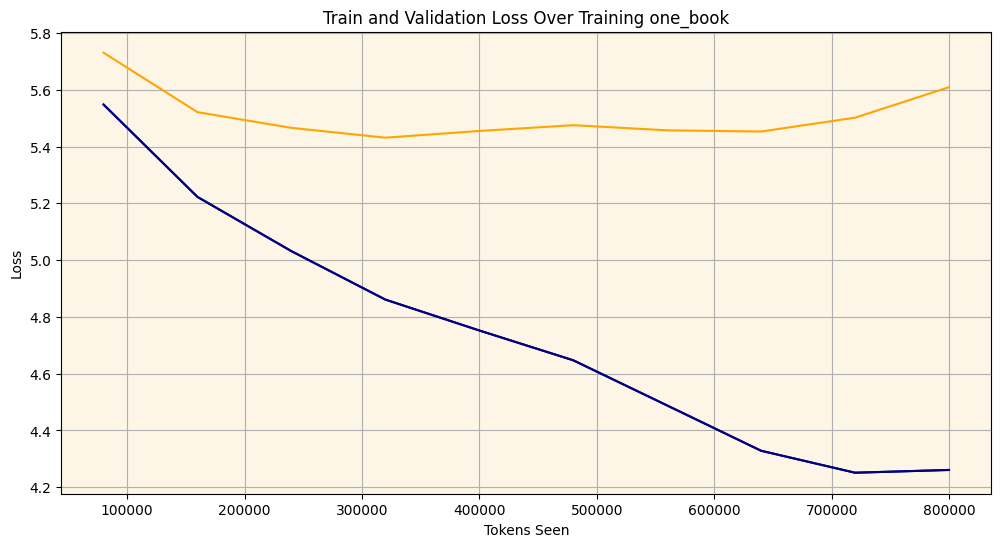

In [13]:
vocab_size = set(oneBookContent)

GPT_CONFIG_124M = {
    "vocab_size": len(vocab_size),
    "context_length": 8,
    "emb_dim": 128,
    "n_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.3,
    "qkv_bias": False,
}


trained_model_oneBook = TrainedGPTModel(model=model,
                                        content=oneBookContent,
                                        cfg=GPT_CONFIG_124M, 
                                        train_ratio=0.80,
                                        num_epochs = 10,
                                        learning_rate=0.001,
                                        log_file_name="one_book_training.log")

trained_model_oneBook.split_data()
trained_model_oneBook.trainingPhase()

train_losses = trained_model_oneBook.train_losses
val_losses = trained_model_oneBook.val_losses
tokens_seen = trained_model_oneBook.track_tokens_seen

plot_loss_function(train_losses, val_losses, tokens_seen, "one_book")
save_model(path=oneBook_model, trained_model=trained_model_oneBook)

### GPT Model Ten Books

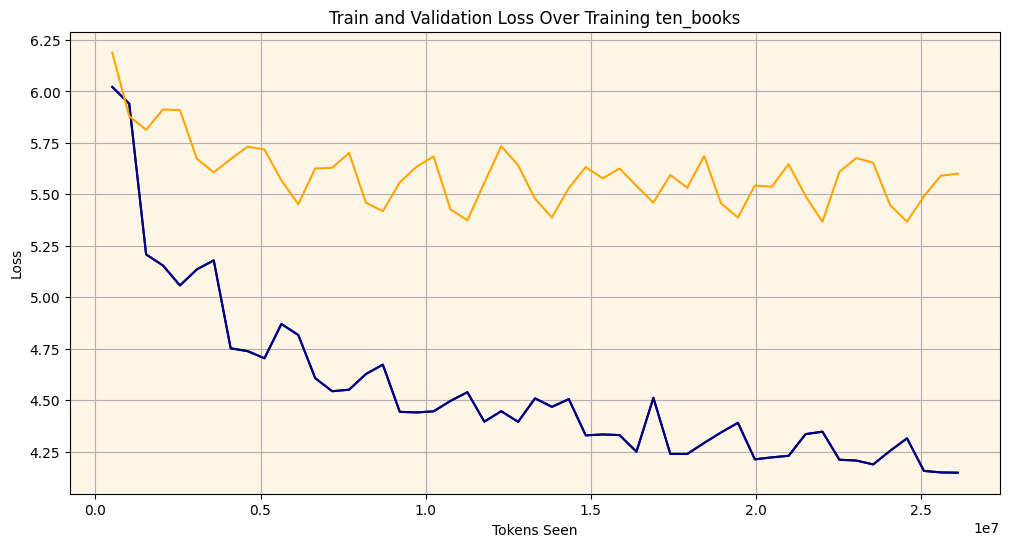

In [9]:

vocab_size = set(tenBooksContent)

GPT_CONFIG_124M = {
    "vocab_size": len(vocab_size),
    "context_length": 8,
    "emb_dim": 128,
    "n_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.3,
    "qkv_bias": False,
}



trained_model_tenBooks = TrainedGPTModel(model=model,
                                        content=tenBooksContent,
                                        cfg=GPT_CONFIG_124M, 
                                        train_ratio=0.80,
                                        num_epochs = 10,
                                        learning_rate=0.001,
                                        log_file_name="ten_books_training.log")

trained_model_tenBooks.split_data()
trained_model_tenBooks.trainingPhase()

train_losses = trained_model_tenBooks.train_losses
val_losses = trained_model_tenBooks.val_losses
tokens_seen = trained_model_tenBooks.track_tokens_seen

plot_loss_function(train_losses, val_losses, tokens_seen, "ten_books")
save_model(path=tenBooks_model, trained_model=trained_model_tenBooks)

### GPT Model Hundred Books

In [ ]:
vocab_size = set(hundredBooksContent)

GPT_CONFIG_124M = {
    "vocab_size": len(vocab_size),
    "context_length": 8,
    "emb_dim": 128,
    "n_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.3,
    "qkv_bias": False,
}



trained_model_hundredBooks = TrainedGPTModel(model=model,
                                            content=hundredBooksContent,
                                            cfg=GPT_CONFIG_124M, 
                                            train_ratio=0.80,
                                            num_epochs = 10,
                                            learning_rate=0.0004,
                                            log_file_name="hundred_book_training.log")

trained_model_hundredBooks.split_data()
trained_model_hundredBooks.trainingPhase()

train_losses = trained_model_hundredBooks.train_losses
val_losses = trained_model_hundredBooks.val_losses
tokens_seen = trained_model_hundredBooks.track_tokens_seen

plot_loss_function(train_losses, val_losses, tokens_seen, "hundred_books")
save_model(path=tenBooks_model, trained_model=trained_model_hundredBooks)

In [31]:
print("[1] one book model\n[2] ten books model\n[3] one hundred books model")


[1] one book model
[2] ten books model
[3] one hundred books model


### Test models

In [ ]:

option = int(input())
prompt = input()

if option == 1:
    selected_model = oneBook_model
elif option == 2:
    selected_model = tenBooks_model
elif option == 3:
    selected_model = hundredBooks_model
else:
    print("Error")
    

try_model(model_path=selected_model, prompt=prompt, max_tokens=150)


[1] one book model
[2] ten books model
[3] one hundred books model
Select your model
User: I am hungry my friend, do you have food?  
GPT: I am hungry my friend, do you have food?             My cousin Elizabeth ,  to th’ ear ,  which thou knowest not for my love ,  and his friends May I with him ,  And we shall follow their lords !   PALAMON .  I must obey your grace .   JAILOR .  I dare assure you ;  I am sure she may deny them .   ARCITE .  No ,  ay ,  he’ll come about you .  I pray you ,  do you make .  But yet ,  I might think .   ARCITE .  And so I ,  I will not go ,  I must be mad .   ARCITE . 
